In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from numpy import exp, loadtxt, pi, sqrt
import astropy
from astropy.io import fits as py
from astropy.table import Table
from numpy import loadtxt
from astropy import constants as const
from astropy import units as u
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.cosmology import Planck15 as planck
from astropy.table import QTable
from astropy.stats import sigma_clip
import healpy as hp
#from healpy.newvisufunc import projview, newprojplot
import math

import sys
sys.path.append('/global/homes/l/lbigwood/LSS/py')
import LSS
import LSS.SV3
import LSS.SV3.cattools as cattools

from desitarget.targets import desi_mask, bgs_mask, mws_mask

#files 
fba = '/project/projectdirs/desi/survey/catalogs/SV3/LSS/random0/fba-000175.fits'
all_randoms = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/random0/rancomb_brightwdup_Alltiles.fits'
brights = '/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/sv3/bright/sv3mtl-bright-hp-2286.ecsv'

nside = 64
orig_density_per_deg = 2500

In [23]:
#Work out tile from rosette 
cattools.tile2rosette(201)

7

In [24]:
def target_density(file):
    
    if file.endswith('.fits'):
        #read file
        f = py.open(file)
        data=f[1].data
        
        #ensure targets dont repeat
        mask,idx = np.unique(data['TARGETID'],return_index=True)
        data = data[idx]
        
        longitude = data['RA']*u.deg
        latitude = data['DEC']*u.deg
        unique_target_list = data['TARGETID']
    
    elif file.endswith('.ecsv'):
        #read file
        data = Table.read(file)
        
        #ensure targets dont repeat
        mask,idx = np.unique(data['TARGETID'],return_index=True)
        data = data[idx]
        
        longitude = data['RA']
        latitude = data['DEC']
        unique_target_list = data['TARGETID']
    
    #set coordinate system, convert units and get rid of nan
    longitude = longitude.to(u.radian)
    longitude = longitude.value

    longitude = longitude[~  np.isnan(longitude)]
    
    latitude = latitude.to(u.radian)
    latitude = latitude.value

    co_latitude = (np.pi/2) - latitude

    co_latitude = co_latitude[~  np.isnan(co_latitude)]
    
    #number of pixels on sphere and pixel area
    npix = hp.nside2npix(nside)
    pixel_area = hp.nside2pixarea(nside,degrees=True)

    #indices of pixels with non-zero density 
    all_pixel_indices = hp.ang2pix(nside, co_latitude, longitude)
    
    #no. targets per pixel, initially 0 
    targets_per_pixel = np.zeros(hp.nside2npix(nside))
    
    #set number of bins to use, so histogram has integer bins for every pixel
    if all_pixel_indices[np.argmax(all_pixel_indices)] - all_pixel_indices[np.argmin(all_pixel_indices)] >0:
        nbins = all_pixel_indices[np.argmax(all_pixel_indices)] - all_pixel_indices[np.argmin(all_pixel_indices)] 
    else:
        nbins = 1
    
    #histogram
    counts,bins,bars = plt.hist(all_pixel_indices,nbins)
    plt.xlabel('Pixel index')
    plt.ylabel('Frequency')

    #setting no. targets per pixel for only non-empty pixels
    filled_pixel_index = []
    filled_targets_per_pixel = []

    #make this not be a for loop
    for i in range(len(counts)):
        if counts[i] != 0:
            filled_pixel_index.append(int(bins[i]))
            filled_targets_per_pixel.append(int(counts[i]))

    filled_pixel_index = np.array(filled_pixel_index)
    filled_targets_per_pixel = np.array(filled_targets_per_pixel)

    #update no. targets per pixel 
    targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel
    
    #mollview map of pixels
    hp.mollview(targets_per_pixel,nest=True)
    hp.graticule(dpar=5, dmer=5) 
    
    return unique_target_list, filled_pixel_index, filled_targets_per_pixel, pixel_area
    

183.2512 deg^2
312.21723601855405 deg^2
183.25120000000004 deg^2


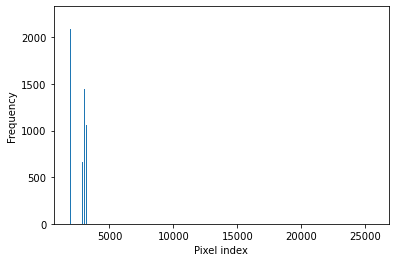

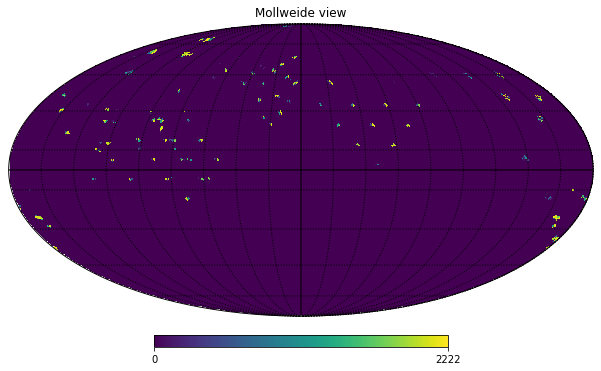

In [39]:
#for randoms 
unique_target_list,filled_pixel_index, filled_targets_per_pixel, pixel_area = target_density(all_randoms)

#correct pixel area based on actual vs expected density 
exp_density_per_pixel = pixel_area * orig_density_per_deg
corr_factor = filled_targets_per_pixel/exp_density_per_pixel
corr_pixel_area = pixel_area * corr_factor

#estimates for sv3 area
SV3_area = len(unique_target_list)/orig_density_per_deg
print('{} deg^2'.format(SV3_area))

SV3_area_2 = pixel_area*len(filled_pixel_index) 
print('{} deg^2'.format(SV3_area_2))

SV3_area_3 = np.sum(corr_pixel_area)
print('{} deg^2'.format(SV3_area_3))

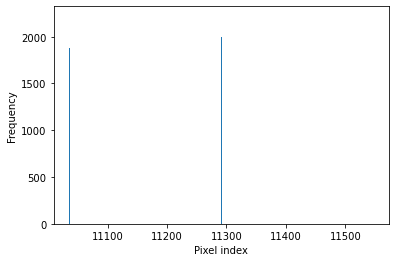

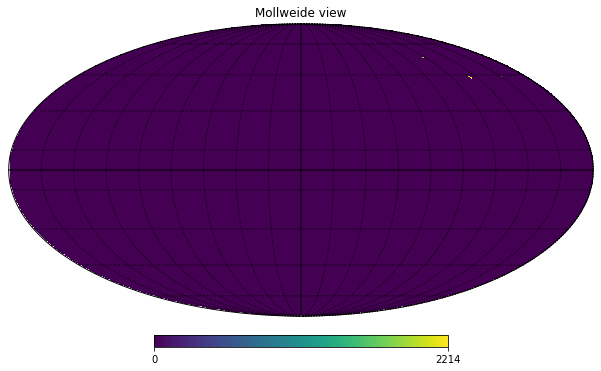

In [40]:
#get density of brights 
unique_target_list,filled_pixel_index, filled_targets_per_pixel, pixel_area = target_density(brights)

#densities per healpixel normalised by expected random density (i.e 2500/deg)
exp_density_per_pixel = pixel_area * orig_density_per_deg
corr_factor = filled_targets_per_pixel/exp_density_per_pixel

In [173]:
#looking at brights priority
data = Table.read(brights)
        
#ensure targets dont repeat
mask,idx = np.unique(data['TARGETID'],return_index=True)
data = data[idx]

#masks of each type 
is_bright = (data["SV3_BGS_TARGET"] & bgs_mask["BGS_BRIGHT"]) != 0
is_faint = (data["SV3_BGS_TARGET"] & bgs_mask["BGS_FAINT"]) != 0
is_faint_hip = (data["SV3_BGS_TARGET"] & bgs_mask["BGS_FAINT_HIP"]) != 0
is_agn = (data["SV3_BGS_TARGET"] & bgs_mask["BGS_WISE"]) != 0

is_mws =  (data["SV3_MWS_TARGET"]) != 0

bright,faint,faint_hip,agn = data[is_bright], data[is_faint], data[is_faint_hip], data[is_agn]
mws = data[is_mws]

#example of how to find priorities
print(np.unique(agn['PRIORITY'].data))

[102000]


In [187]:
#how many targets of each type 
print(len(faint))
print(len(bright))
print(len(faint_hip))
print(len(agn))

#overlap example
faint_faint_hip = data[(is_faint & is_faint_hip)]
bright_mws = data[(is_bright & is_mws)]
print(len(bright_mws)) #get zero: no overlap?

#lists all targets and types
"""
bitnames = np.array(bgs_mask.names())  # ADM note the array conversion to help manipulation.
bitvals = [bgs_mask[name] for name in bitnames]
for data in data:
    w = np.where( (data["SV3_BGS_TARGET"] & bitvals) != 0)[0]
    print(data["SV3_BGS_TARGET"], bitnames[w])
"""

#looking at priorities of mws targets 
is_mws_2 =  (data["SV3_MWS_TARGET"] & mws_mask["MWS_WD"]) != 0
mws_2 = data[is_mws_2]
print(np.unique(mws_2['REF_EPOCH'].data))

1990
2917
408
7
0
[2015.5]
